The very first attampt to use QuantLib and BS model and generate a call price.
stock_price is stored in quote so we can change the value later.

In [111]:
import QuantLib as ql

# option data
maturity_date = ql.Date(30, 10, 2020)
stock_price = ql.SimpleQuote(170.0)
strike_price = 150
volatility = 0.10 # the historical vols for a year
dividend_rate =  0.002
risk_free_rate = 0.003
option_type = ql.Option.Call

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(27, 10, 2019)
ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(stock_price)
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)


Analytic Black-Scholes calculation:

In [116]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
delta = european_option.delta()
gamma = european_option.gamma()
vega = european_option.vega()
rho = european_option.rho()

print("The theoretical price is ", bs_price)
print("The delta is ", delta)
print("The gamma is ", gamma)
print("The vega is ", vega)
print("The rho is ", rho)

The theoretical price is  50.06064169029187
The delta is  0.9962419674364388
The gamma is  0.0002774795883757332
The vega is  1.1220818423084395
The rho is  150.8226860632643


In [117]:
#prepare for plotting
xs_bs = np.linspace(100, 200, 400)
ys_bs = []
for x in xs_bs:
    stock_price.setValue(x)
    ys_bs.append(european_option.NPV())

Instead of using analytic Black-Scholes formula, we can use Monte-Carlo simulation.

In [118]:
engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                      timeSteps=20,
                                      requiredSamples=250000)
european_option.setPricingEngine(engine)
bs_price = european_option.NPV()
error = european_option.errorEstimate()
print("The monte carlo theoretical price is ", bs_price)
print("The monte carlo error is ", error)

The monte carlo theoretical price is  50.05677602548663
The monte carlo error is  0.04022781421518914


[100.         105.26315789 110.52631579 115.78947368 121.05263158
 126.31578947 131.57894737 136.84210526 142.10526316 147.36842105
 152.63157895 157.89473684 163.15789474 168.42105263 173.68421053
 178.94736842 184.21052632 189.47368421 194.73684211 200.        ]
[4.4834036618989665e-05, 0.0007765123609913305, 0.004790301775550994, 0.022702864678737066, 0.08034539859559052, 0.25644671755212156, 0.6544886785695262, 1.4408779053542622, 2.761563013115562, 4.789079271166618, 7.534440804255337, 10.935957476653156, 15.055418668961426, 19.522386567602773, 24.257630336657776, 29.32315783025189, 34.43064549098972, 39.58499672900811, 44.843966940949095, 50.05809508598931]
[100.         100.25062657 100.50125313 100.7518797  101.00250627
 101.25313283 101.5037594  101.75438596 102.00501253 102.2556391
 102.50626566 102.75689223 103.0075188  103.25814536 103.50877193
 103.7593985  104.01002506 104.26065163 104.5112782  104.76190476
 105.01253133 105.26315789 105.51378446 105.76441103 106.01503759

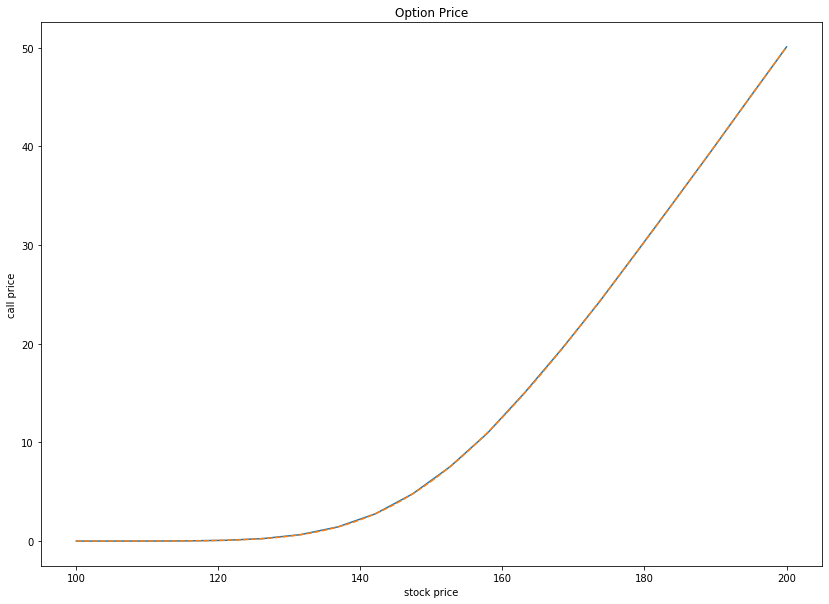

In [122]:
%matplotlib inline
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

xs = np.linspace(100, 200, 20)
ys = []
for x in xs:
    stock_price.setValue(x)
    ys.append(european_option.NPV())
    
print(xs)
print(ys)
print(xs_bs)
print(ys_bs)

plt.figure(figsize=(14,10))
plt.plot(xs, ys)
plt.plot(xs_bs, ys_bs, linestyle='dashed')
plt.xlabel('stock price') 
plt.ylabel('call price') 
plt.title('Option Price') 
plt.show() 


An Option Class which stores all the options info; return BS model call price; return the wanted data set for training purpose.

In [39]:
class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        
    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.bs_price)
        return data_set


Functions to help in converting and auto-generate specific numbers of options sample data for training.

In [40]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,10,30)
    end_maturity = datetime.datetime(2022,10,30)

    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0.001, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.BSM_price())
    return options

def random_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volability', 'risk_free_rate', 'call_price']
    return dataframe


In [41]:
n = 30000
df = random_options_pd(n)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
print(df)
print(df.isnull().any())
n_train =  (int)(0.8 * n)
train = df[0:n_train]
X_train = train[['stock_price', 'strike_price', 'maturity', 'devidends', 'volability', 'risk_free_rate']].values
y_train = train['call_price'].values
test = df[n_train+1:n]
X_test = test[['stock_price', 'strike_price', 'maturity', 'devidends', 'volability', 'risk_free_rate']].values
y_test = test['call_price'].values

       stock_price  strike_price  maturity  devidends  volability  \
0         0.899054           317  1.665753   0.000451    0.876279   
1         1.673684           285  1.468493   0.001955    0.249672   
2         2.818713           171  2.953425   0.002110    0.541825   
3         1.818182            88  2.810959   0.002848    0.717402   
4         0.608142           393  1.660274   0.000383    0.145617   
...            ...           ...       ...        ...         ...   
29995     0.891089           404  2.386301   0.000273    0.321346   
29996     0.949664           298  2.090411   0.001276    0.444514   
29997     1.452899           276  1.082192   0.000365    0.451458   
29998     2.207317            82  1.734247   0.001693    0.335629   
29999     1.471572           299  2.463014   0.000667    0.316662   

       risk_free_rate  call_price  
0            0.001876    0.358113  
1            0.001640    0.678358  
2            0.001120    1.902055  
3            0.001448    1.

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
from tensorflow import squeeze

# problem is not because of my custom activation function, it's because of exponential activation not applied in this case

nodes = 100
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('exponential'))
          
model.compile(loss='mse',optimizer='rmsprop')

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))


Train on 21600 samples, validate on 2400 samples
Epoch 1/10
 - 1s - loss: nan - val_loss: nan
Epoch 2/10
 - 1s - loss: nan - val_loss: nan
Epoch 3/10
 - 1s - loss: nan - val_loss: nan
Epoch 4/10
 - 1s - loss: nan - val_loss: nan
Epoch 5/10
 - 1s - loss: nan - val_loss: nan
Epoch 6/10
 - 1s - loss: nan - val_loss: nan
Epoch 7/10
 - 1s - loss: nan - val_loss: nan
Epoch 8/10
 - 1s - loss: nan - val_loss: nan
Epoch 9/10
 - 1s - loss: nan - val_loss: nan
Epoch 10/10
 - 1s - loss: nan - val_loss: nan
The mean squared error (MSE) for the test data set is: nan


A modified NN which gives really good results. Haven't adapted to their scaling method.

In [100]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

model = Sequential()
model.add(Dense(50,input_dim=6,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(X_train, y_train, epochs=50, validation_split=0.1,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)

y_test_hat = model.predict(X_test)


Train on 21600 samples, validate on 2400 samples
Epoch 1/50
 - 1s - loss: 2.2007 - val_loss: 0.2228
Epoch 2/50
 - 1s - loss: 0.0716 - val_loss: 0.0304
Epoch 3/50
 - 1s - loss: 0.0979 - val_loss: 0.0442
Epoch 4/50
 - 1s - loss: 0.0180 - val_loss: 0.0092
Epoch 5/50
 - 1s - loss: 0.0414 - val_loss: 0.0179
Epoch 6/50
 - 1s - loss: 0.0150 - val_loss: 0.0097
Epoch 7/50
 - 1s - loss: 0.0282 - val_loss: 0.0786
Epoch 8/50
 - 2s - loss: 0.0339 - val_loss: 0.0066
Epoch 9/50
 - 1s - loss: 0.0339 - val_loss: 0.0226
Epoch 10/50
 - 1s - loss: 0.0097 - val_loss: 0.0039
Epoch 11/50
 - 1s - loss: 0.0356 - val_loss: 0.0114
Epoch 12/50
 - 1s - loss: 0.0285 - val_loss: 0.0132
Epoch 13/50
 - 1s - loss: 0.0172 - val_loss: 0.0039
Epoch 14/50
 - 1s - loss: 0.0684 - val_loss: 0.0151
Epoch 15/50
 - 1s - loss: 0.0082 - val_loss: 0.0090
Epoch 16/50
 - 1s - loss: 0.0080 - val_loss: 0.0062
Epoch 17/50
 - 1s - loss: 0.0061 - val_loss: 0.0075
Epoch 18/50
 - 1s - loss: 0.0141 - val_loss: 0.0549
Epoch 19/50
 - 1s - loss

In [101]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

model = Sequential()

nodes = 100
model.add(Dense(nodes,input_dim=6))
model.add(LeakyReLU())

model.add(Dense(nodes,activation='elu'))

model.add(Dense(nodes,activation='relu'))

model.add(Dense(nodes,activation='elu'))

model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(X_train, y_train, epochs=20, validation_split=0.1,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)
print(y_train_hat)

y_test_hat = model.predict(X_test)
print(y_test_hat)

Train on 21600 samples, validate on 2400 samples
Epoch 1/20
 - 1s - loss: 0.9308 - val_loss: 0.0142
Epoch 2/20
 - 1s - loss: 0.0653 - val_loss: 0.0073
Epoch 3/20
 - 1s - loss: 0.0741 - val_loss: 0.0283
Epoch 4/20
 - 1s - loss: 0.0286 - val_loss: 0.0537
Epoch 5/20
 - 1s - loss: 0.1498 - val_loss: 0.6596
Epoch 6/20
 - 1s - loss: 0.1051 - val_loss: 0.0085
Epoch 7/20
 - 1s - loss: 0.0180 - val_loss: 0.0389
Epoch 8/20
 - 1s - loss: 0.0250 - val_loss: 0.0144
Epoch 9/20
 - 1s - loss: 0.0284 - val_loss: 0.0073
Epoch 10/20
 - 1s - loss: 0.0742 - val_loss: 0.1895
Epoch 11/20
 - 1s - loss: 0.0198 - val_loss: 0.0050
Epoch 12/20
 - 1s - loss: 0.0152 - val_loss: 0.0172
Epoch 13/20
 - 1s - loss: 0.0146 - val_loss: 0.0284
Epoch 14/20
 - 1s - loss: 0.0196 - val_loss: 0.0097
Epoch 15/20
 - 1s - loss: 0.0208 - val_loss: 0.0113
Epoch 16/20
 - 1s - loss: 0.0620 - val_loss: 0.0110
Epoch 17/20
 - 1s - loss: 0.0094 - val_loss: 0.0314
Epoch 18/20
 - 1s - loss: 0.0132 - val_loss: 0.0164
Epoch 19/20
 - 1s - loss

Mean Squared Error:       0.010251634180123145
Root Mean Squared Error:  0.10125035397529801
Mean Absolute Error:      0.07478967996400736
Mean Percent Error:       0.06956803492083945


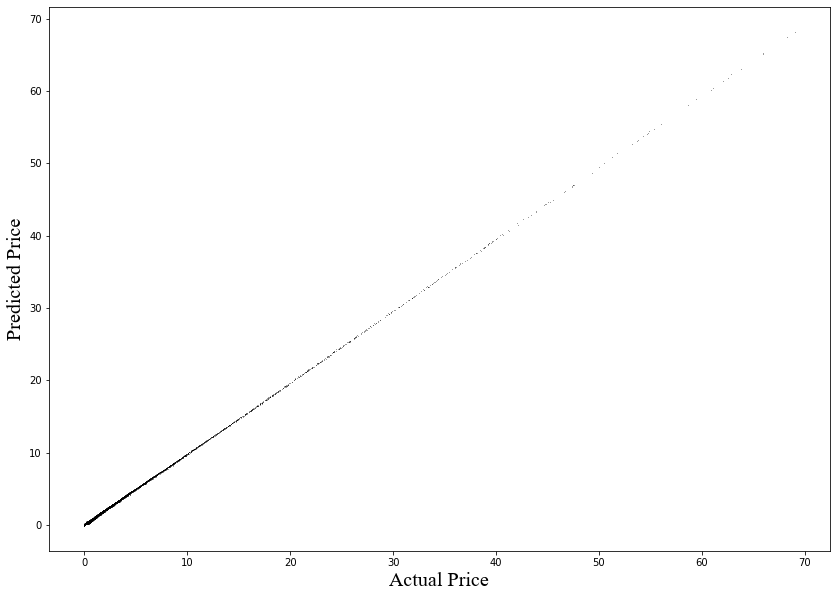

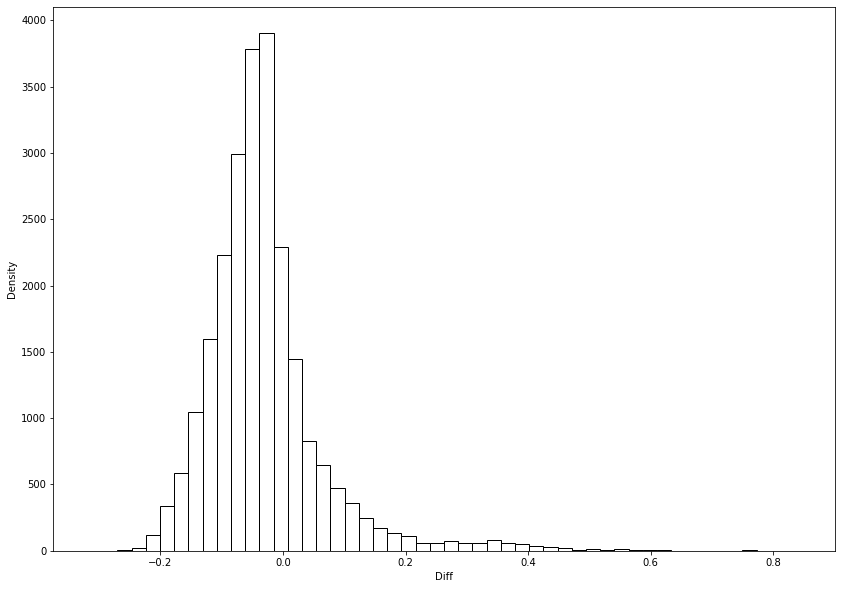

In [102]:
from statistics import *
from math import sqrt
import matplotlib as mpl
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats

#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat = squeeze(y_train_hat).numpy()
CheckAccuracy(y_train, y_train_hat)

Mean Squared Error:       0.010282778586448528
Root Mean Squared Error:  0.10140403634199444
Mean Absolute Error:      0.07498966964208091
Mean Percent Error:       0.06978944899583643


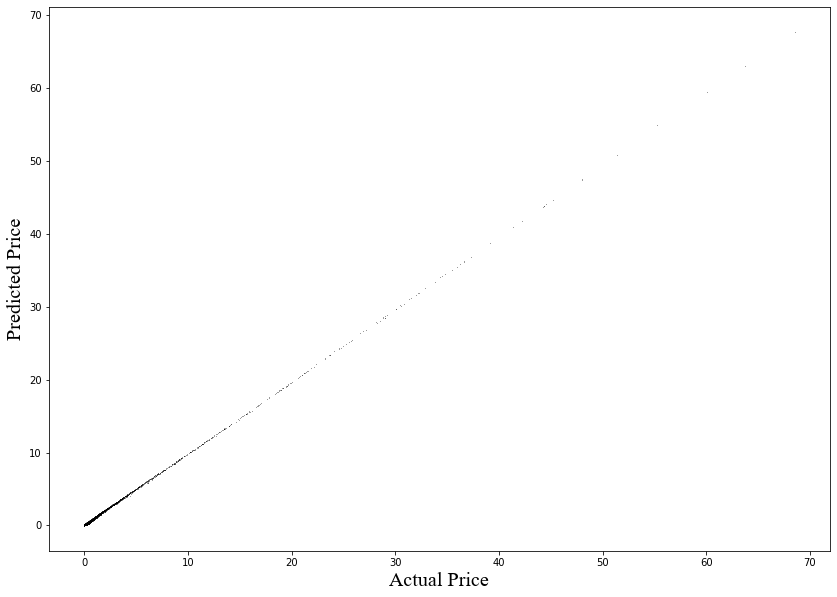

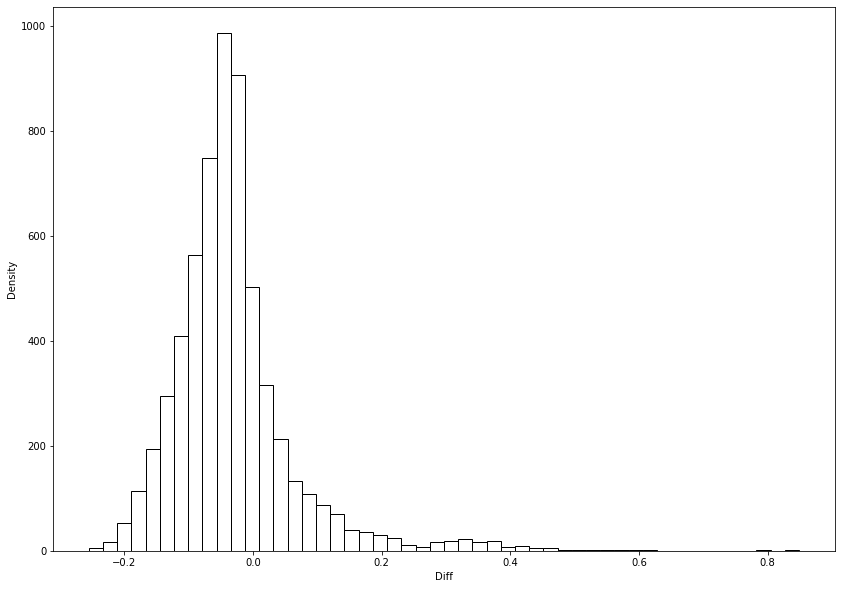

In [103]:
y_test_hat = squeeze(y_test_hat).numpy()
CheckAccuracy(y_test, y_test_hat)